In [1]:
%%time
from pycolator import *

idCol = 'SpecId'
scoreCol = 'NuXL:score'
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'class-specific_q-val', 'Rank', 'temp_score', 'percolator_score']

dSlow = readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)
features = [x for x in list(dSlow.columns) if (x not in excluded)]

file read...
strings converted to floats...
q-values estimated...
ranks computed...
features normed...
floats converted to ints...
file ready!
Wall time: 18.5 s


In [108]:
# determine which cols to imputate and fill them with nan for nXLs

df = dSlow
xlcol = 'NuXL:isXL'
ls = []
for col in df.columns:
    ls.append([col])
    ls[-1].append(min(df[col]))
    ls[-1].append(max(df[col]))
    ls[-1].append(min(df.loc[df[xlcol] == 1, col]))
    ls[-1].append(max(df.loc[df[xlcol] == 1, col]))
    ls[-1].append(min(df.loc[df[xlcol] == 0, col]))
    ls[-1].append(max(df.loc[df[xlcol] == 0, col]))

df = pd.DataFrame(ls, columns = ['Col','Min Ges', 'Max Ges', 'Min XL', 'Max XL', 'Min nXL', 'Max nXL'])
colsToImputate = df.loc[(df['Min nXL'] == df['Max nXL']) & (df['Min XL'] != df['Max XL']), 'Col']
print(list(colsToImputate))
if(all(dSlow.loc[dSlow[xlcol] == 0, colsToImputate] == 0)):
    dSlow.loc[dSlow[xlcol] == 0, colsToImputate] = np.nan
else:
    print('reexamine colsToImputate')
    
df.loc[(df['Min nXL'] == df['Max nXL']) & (df['Min XL'] != df['Max XL'])]

['NuXL:tag_XLed', 'NuXL:tag_shifted', 'NuXL:marker_ions_score', 'NuXL:partial_loss_score', 'NuXL:pl_MIC', 'NuXL:pl_err', 'NuXL:pl_Morph', 'NuXL:pl_modds', 'NuXL:pl_pc_MIC', 'NuXL:pl_im_MIC', 'NuXL:NA_MASS_z0', 'NuXL:NA_length', 'NuXL:XL_U', 'NuXL:XL_C', 'NuXL:XL_G', 'NuXL:XL_A']


,Col,Min Ges,Max Ges,Min XL,Max XL,Min nXL,Max nXL
29,NuXL:tag_XLed,0,1,0,1,0,0
31,NuXL:tag_shifted,0,1,0.0434783,1,0,0
35,NuXL:marker_ions_score,0,1,0,1,0,0
36,NuXL:partial_loss_score,0,1,0,1,0,0
37,NuXL:pl_MIC,0,1,0.0128985,1,0,0
38,NuXL:pl_err,0,1,0,1,0,0
39,NuXL:pl_Morph,0,1,0.0563894,1,0,0
40,NuXL:pl_modds,0,1,7.55265e-09,1,0,0
41,NuXL:pl_pc_MIC,0,1,0,1,0,0
42,NuXL:pl_im_MIC,0,1,0,1,0,0


In [109]:
# train imputer

%%time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer()#estimator = svm.LinearSVC(), max_iter=10)

falseTrain = dSlow.loc[(dSlow.Rank == 1) & (dSlow.Label == 0)]
trueTrain = dSlow.loc[(dSlow.Rank == 1) & (dSlow['q-val'] <= 0.05) & (dSlow.Label == 1)]
train = falseTrain[features].values.tolist() + trueTrain[features].values.tolist()

imp.fit(train)

#print(imp.transform(dSlow[features]))

Wall time: 11.2 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, tol=0.001, verbose=0)

In [111]:
dSlow[features] = imp.transform(dSlow[features])

In [105]:
df = pd.DataFrame(imp.transform(dSlow[features]), columns=features)
df[list(colsToImputate) + [xlcol]]

,NuXL:tag_XLed,NuXL:tag_shifted,NuXL:marker_ions_score,NuXL:partial_loss_score,NuXL:pl_MIC,NuXL:pl_err,NuXL:pl_Morph,NuXL:pl_modds,NuXL:pl_pc_MIC,NuXL:pl_im_MIC,NuXL:NA_MASS_z0,NuXL:NA_length,NuXL:XL_U,NuXL:XL_C,NuXL:XL_G,NuXL:XL_A,NuXL:isXL
0,0.452354,0.408423,0.053178,0.000098,0.196186,-0.508800,1.952289e-05,-0.078279,0.032511,-1.407904,0.077582,0.232691,0.097666,0.422486,0.177989,0.301852,0.0
1,0.460150,0.415910,0.053049,0.000098,0.196192,-0.457680,1.836463e-05,-0.079116,0.032511,-1.407827,0.055587,0.203784,0.097677,0.422479,0.177984,0.301853,0.0
2,0.327225,0.273990,0.052836,0.000091,0.196205,-0.405548,1.373274e-05,-0.091081,0.032518,-1.407741,0.021888,0.176764,0.097744,0.422419,0.178017,0.301815,0.0
3,0.452639,0.410522,0.052370,0.000098,0.196223,-0.006494,1.541262e-05,-0.042550,0.032517,-1.407433,0.549493,0.678033,0.097734,0.422435,0.177961,0.301865,0.0
4,0.420168,0.377731,0.052190,0.000098,0.196232,-0.034364,1.418600e-05,-0.047536,0.032517,-1.407333,0.549714,0.675395,0.097735,0.422438,0.177958,0.301864,0.0
5,0.332835,0.313716,0.052625,0.000099,0.196216,-0.336340,1.336927e-05,-0.006994,0.032508,-1.407593,0.379250,0.532226,0.097704,0.422472,0.177964,0.301854,0.0
6,0.360609,0.316786,0.052388,0.000092,0.196226,-0.308182,1.205654e-05,-0.067828,0.032522,-1.407483,0.285108,0.424862,0.097756,0.422410,0.178010,0.301819,0.0
7,0.335942,0.316367,0.052567,0.000099,0.196219,-0.416462,1.314018e-05,-0.013726,0.032508,-1.407561,0.363648,0.516662,0.097693,0.422482,0.177967,0.301852,0.0
8,0.338175,0.318774,0.052510,0.000100,0.196222,-0.507364,1.288393e-05,-0.019941,0.032508,-1.407528,0.352657,0.505980,0.097682,0.422491,0.177971,0.301850,0.0
9,0.338435,0.318710,0.052508,0.000100,0.196222,-0.474879,1.282264e-05,-0.018923,0.032508,-1.407526,0.353261,0.504498,0.097687,0.422488,0.177969,0.301851,0.0


In [71]:
df = dSlow
for col in colsToImputate:
    df.loc[(df[xlcol] == 0), col] = np.mean(df.loc[(df[xlcol] == 1), col])
df[list(colsToImputate) + [xlcol]]

,NuXL:tag_XLed,NuXL:tag_shifted,NuXL:marker_ions_score,NuXL:partial_loss_score,NuXL:pl_MIC,NuXL:pl_err,NuXL:pl_Morph,NuXL:pl_modds,NuXL:pl_pc_MIC,NuXL:pl_im_MIC,NuXL:NA_MASS_z0,NuXL:NA_length,NuXL:XL_U,NuXL:XL_C,NuXL:XL_G,NuXL:XL_A,NuXL:isXL
15534,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
15647,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
12279,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
14073,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
14191,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
77656,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
28032,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
77841,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
78047,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0
77762,0.167833,0.171664,0.040264,0.114259,0.148856,0.112142,0.221414,0.006008,0.034733,0.024988,0.493420,0.577234,0.085732,0.412317,0.195241,0.30671,0


In [ ]:
# looking for more features with missing values
dSlow.loc[dSlow[xlcol] == 1, features].hist()
plt.savefig('Test2.png', dpi = 300)

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3670, length of negative training set: 28394
Optimal parameters are C=10 and class_weight={0: 10, 1: 10}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3963, length of negative training set: 28394
Optimal parameters are C=10 and class_weight={0: 10, 1: 10}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 4400, length of negative training set: 28396
Optimal parameters are C=1 and class_weight={0: 10, 1: 10}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 286.88301681421484.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 4571, length of negative training set: 28394
Optimal parameters are C=1 and class_weight={0: 10, 1: 10}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 4533, length of negative training set: 28394
Optimal parameters

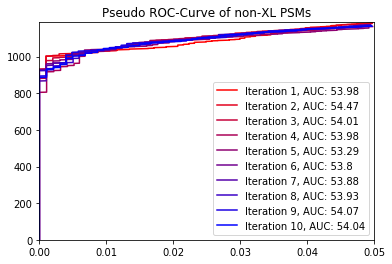

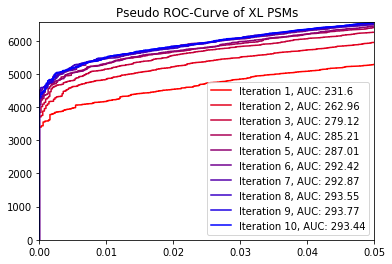

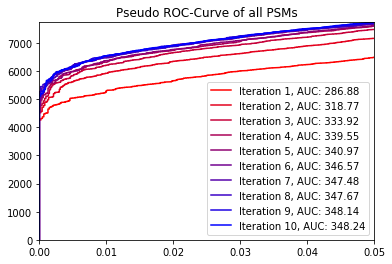

file read...
strings converted to floats...
q-values estimated...
ranks computed...
features normed...
floats converted to ints...
file ready!
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3654, length of negative training set: 28394
Optimal parameters are C=10 and class_weight={0: 10, 1: 10}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3888, length of negative training set: 28394
Optimal parameters are C=1 and class_weight={0: 10, 1: 10}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 4400, length of negative training set: 28396
Optimal parameters are C=10 and class_weight={0: 10, 1: 10}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 289.3754841474763.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 4491, length of negative training set: 28394
Optimal parameters are C=1 and class_weight={0: 10, 1: 10}.



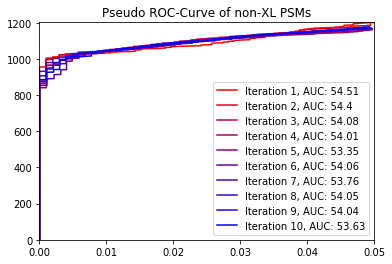

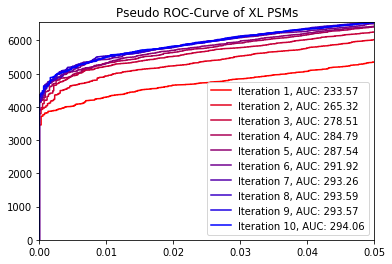

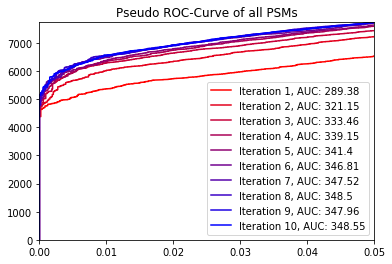

Wall time: 10min 56s


In [2]:
%%time
# test percolator

saveName = '../results/Imputation/imp_{}.png'

pImp = percolator_experimental(dSlow, idCol, features, plotSaveName = saveName, multImputation = True)

dSlow = readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)

saveName = '../results/Imputation/no_imp_{}.png'

pNImp = percolator_experimental(dSlow, idCol, features, plotSaveName = saveName, multImputation = False)